In [33]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [34]:
import numpy as np
import scipy.io as sio
import netCDF4 as nc
import glob, os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.colors as mcolors
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
from xgcm import Grid

In [35]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [36]:
%cd /work/eay/MITgcm_data/Experiment32/
#%ls
grid = xr.open_dataset('grid.nc')
Salt = (xr.open_dataset('Salt.nc'))['S']
U    = (xr.open_dataset('U.nc'))['U']
V    = (xr.open_dataset('V.nc'))['V']
W    = (xr.open_dataset('W.nc'))['W']
Eta  = (xr.open_dataset('Eta.nc'))['Eta']
xq = grid['X']
yq = grid['Y']
zl = grid['Z']

%cd /work/eay/MITgcm_data/

/work0/eay/MITgcm_data/Experiment32
/work0/eay/MITgcm_data


In [37]:
print(U.shape,V.shape,W.shape)
print(Eta)

(150, 250, 1000, 601) (150, 250, 1001, 600) (150, 250, 1000, 600)
<xarray.DataArray 'Eta' (T: 150, Y: 1000, X: 600)>
[90000000 values with dtype=float32]
Coordinates:
  * Y        (Y) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
  * X        (X) float64 50.0 150.0 250.0 ... 5.975e+04 5.985e+04 5.995e+04
  * T        (T) float64 0.0 1.8e+03 3.6e+03 ... 2.646e+05 2.664e+05 2.678e+05
Attributes:
    long_name:    free-surface_r-anomaly
    units:        m
    coordinates:  XC YC iter


In [38]:
%%time

index_z = 0 # 1 for momentum balance just below surface, avoiding wind complications
grid_info= Grid(grid, coords={'X': {'center': 'X', 'outer': 'Xp1'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'Y', 'outer': 'Yp1'}});
u = grid_info.interp(U[:,index_z,:,:],axis='X')
print('done u')
v = grid_info.interp(V[:,index_z,:,:],axis='Y')
#w = (W[:,index_z,:,:])
print(grid_info)
w_5 = (W[:,5,:,:])
w_10 = (W[:,10,:,:])
w_15 = (W[:,15,:,:])
w_20 = (W[:,20,:,:])
w_25 = (W[:,25,:,:])


done u
<xgcm.Grid>
X Axis (periodic):
  * center   X --> outer
  * outer    Xp1 --> center
Y Axis (periodic):
  * center   Y --> outer
  * outer    Yp1 --> center
CPU times: user 746 ms, sys: 1.65 s, total: 2.39 s
Wall time: 2.4 s


In [39]:
print(U.Z)

<xarray.DataArray 'Z' (Z: 250)>
array([ -0.05,  -0.15,  -0.25, ..., -24.75, -24.85, -24.95])
Coordinates:
  * Z        (Z) float64 -0.05 -0.15 -0.25 -0.35 ... -24.65 -24.75 -24.85 -24.95
Attributes:
    long_name:  vertical coordinate of cell center
    units:      meters
    positive:   up


In [40]:
#computing Ekman velocity:
tau=0.03;
A_v=1.e-4;
f=8.e-5;
rho=1024;
V_0=tau/(rho*(A_v*f)**0.5);
#D_E=((2*A_v)/f)**0.5;
u_E=V_0*np.cos((np.pi/4))#+(z/D_E))*np.exp(z/D_E); #uncomment for function of depth
v_E=V_0*np.sin((np.pi/4))#+(z/D_E))*np.exp(z/D_E);

In [41]:
print(u.shape,v.shape,Salt.shape)
#print(u)
#test=100
#print((u[test+1,500,500]-u[test-1,500,500])/3600)
#print(dudt[test,500,500])
print(U.Z)

(150, 1000, 600) (150, 1000, 600) (150, 250, 1000, 600)
<xarray.DataArray 'Z' (Z: 250)>
array([ -0.05,  -0.15,  -0.25, ..., -24.75, -24.85, -24.95])
Coordinates:
  * Z        (Z) float64 -0.05 -0.15 -0.25 -0.35 ... -24.65 -24.75 -24.85 -24.95
Attributes:
    long_name:  vertical coordinate of cell center
    units:      meters
    positive:   up


In [42]:
index = 65 #time index

#Putting all terms on LHS of momentum equation except for the forcing!
## X COMPONENT
dudt = u.differentiate("T")
ududx= u*(u.differentiate("X"))
vdudy= v*(u.differentiate("Y"))

coriolis_term=-f*(v)
PGF  = 9.81*(Eta.differentiate("X"))
hor_viscosity =-10*(u.differentiate("X")).differentiate("X")-10*(u.differentiate("Y")).differentiate("Y")
vert_viscosity=-1e-4*(grid_info.interp(U[index,0:5,:,:],axis='X').differentiate("Z")).differentiate("Z")
vert_viscosity=vert_viscosity[0,:,:]

wind_forcing = xr.zeros_like(Eta)+0.0/(1024*0.1)
error = dudt+ududx+vdudy+coriolis_term+PGF+hor_viscosity+vert_viscosity-wind_forcing


term1 = dudt
term2 = ududx + vdudy
term3 = -f*(v-v_E)+PGF
#term4 = term1+term2+term3
term4 = term1+term2+term3+hor_viscosity-(error-np.nanmean(error[index,:,400:500]))

print('done')

done


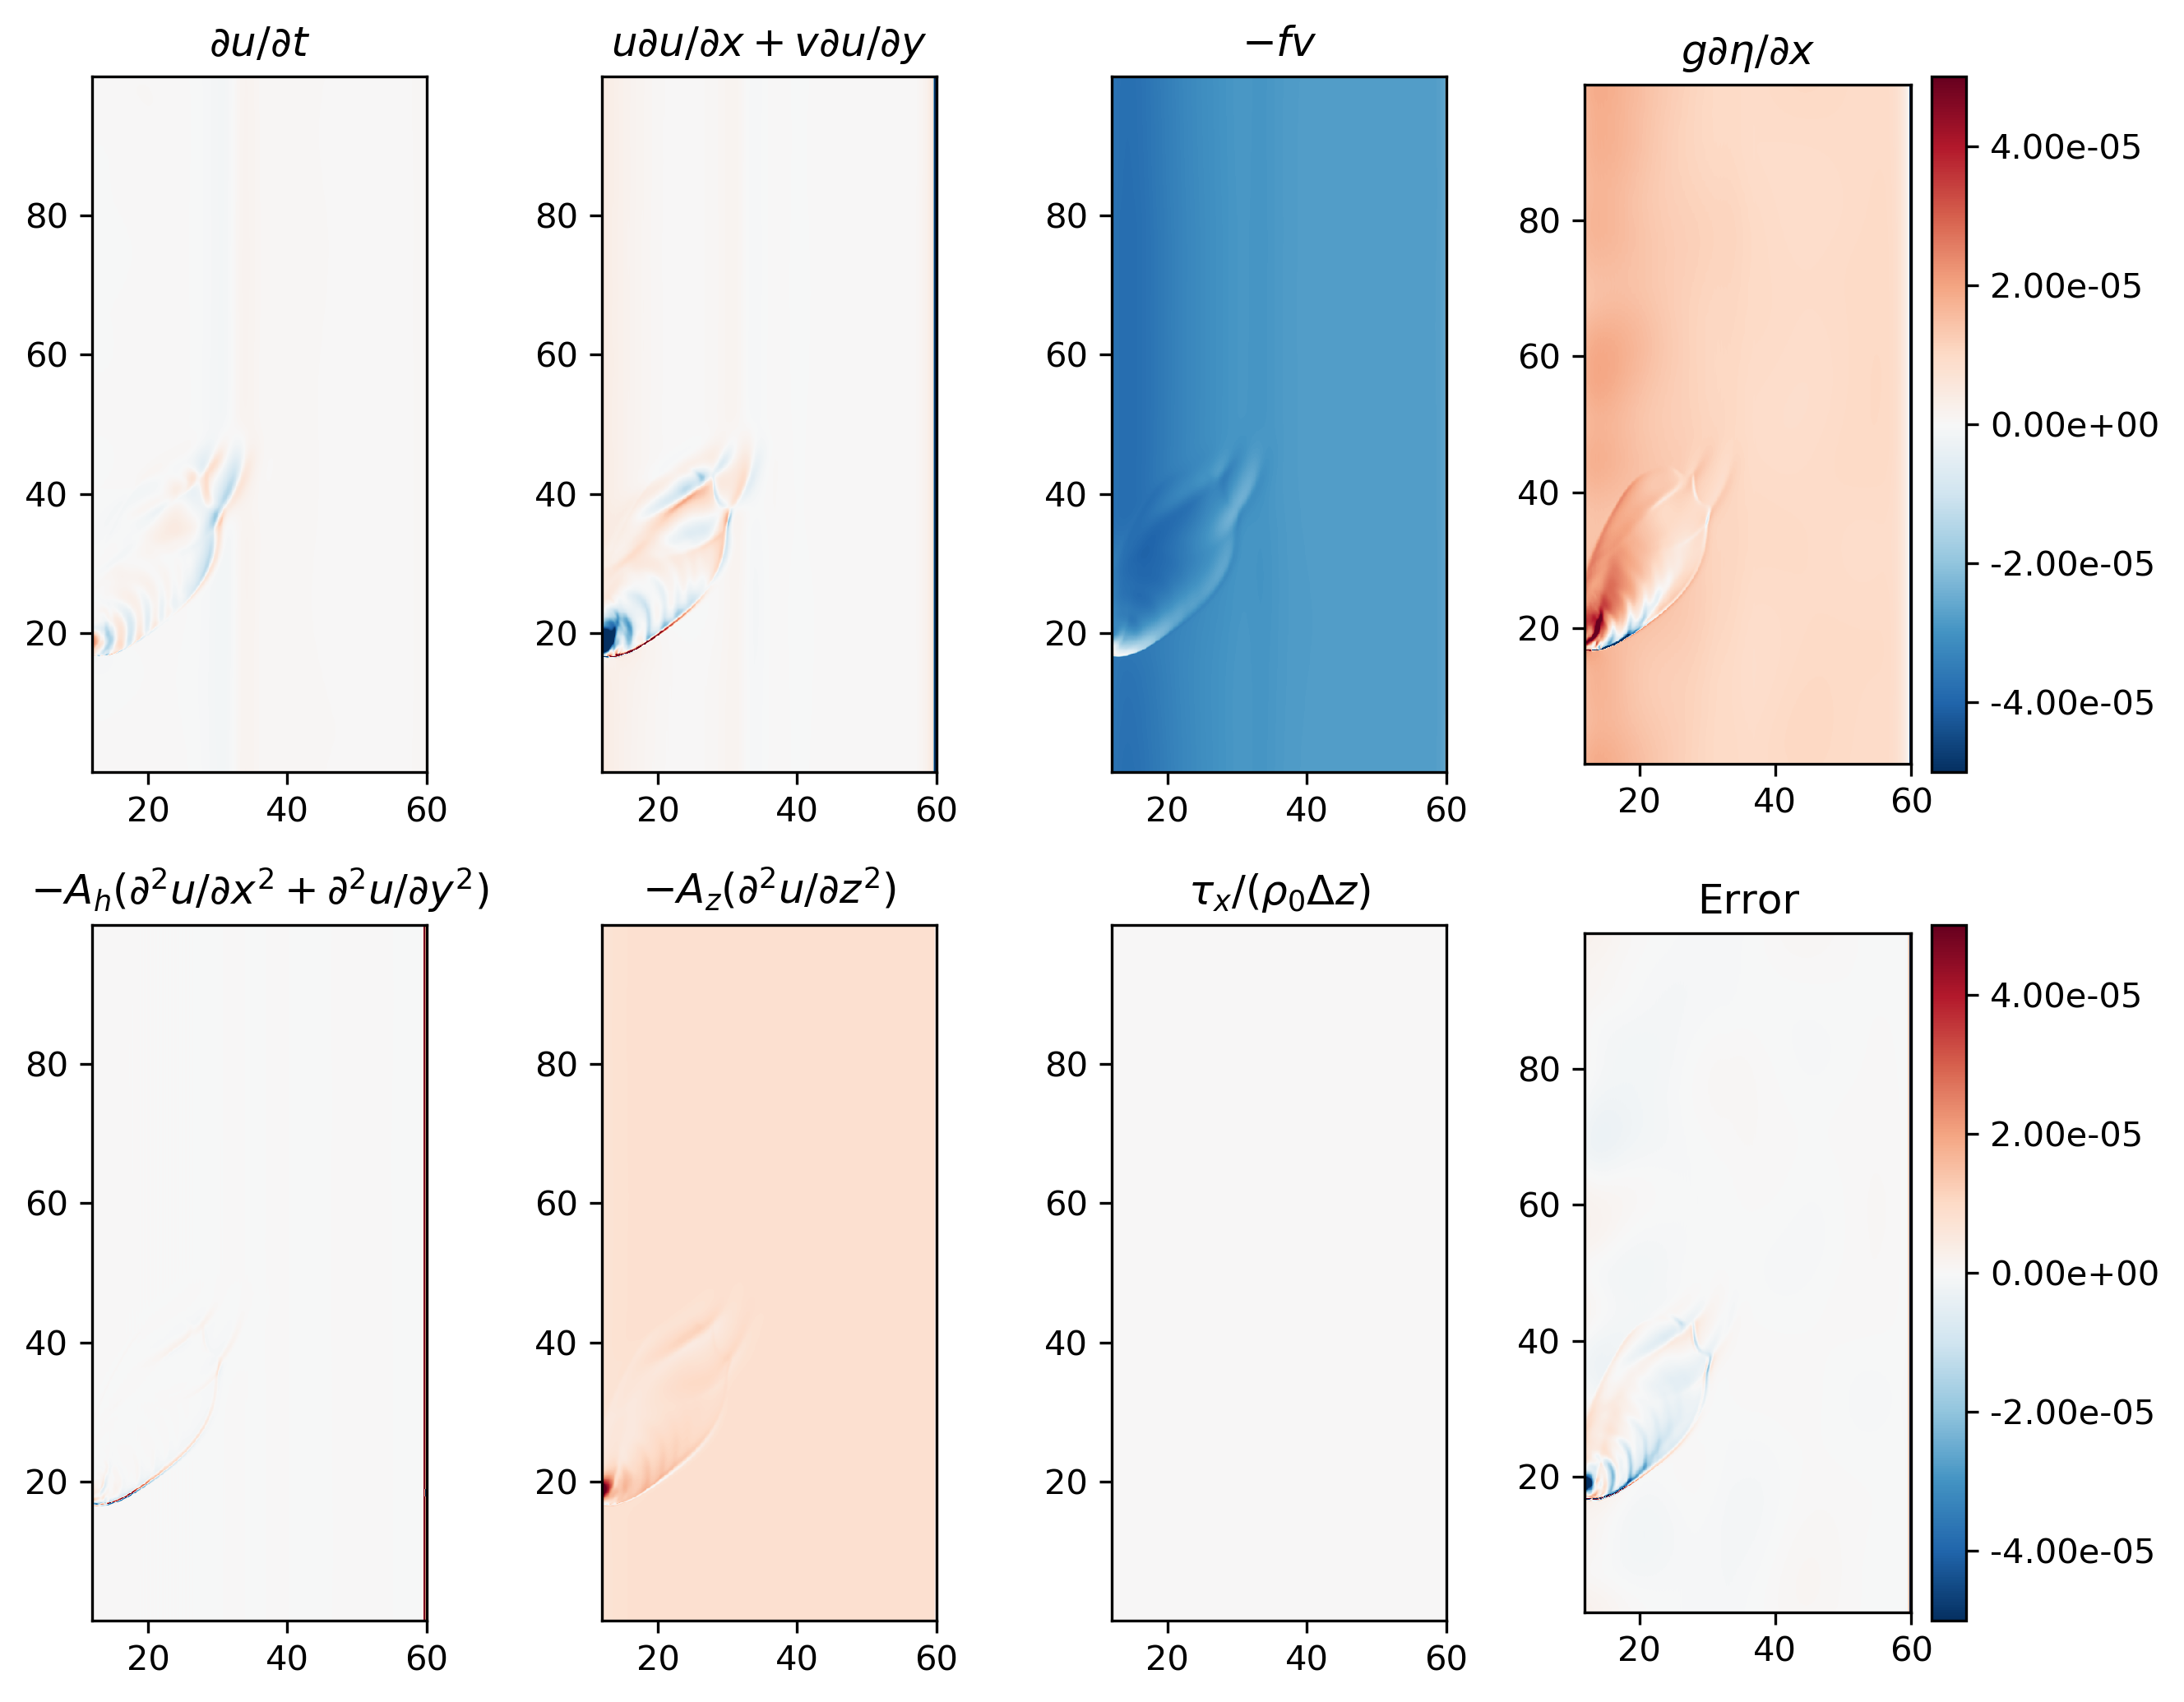

In [43]:
plt.figure(figsize=(9,7),dpi=300)


cmin=-.5e-4; cmax=.5e-4;
plt.subplot(2,4,1)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,dudt[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial u/\partial t$')
#plt.colorbar()

plt.subplot(2,4,2)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,ududx[index]+vdudy[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$u \partial u/\partial x+v \partial u/\partial y$')
#plt.colorbar()



plt.subplot(2,4,3)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,coriolis_term[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-fv$')


plt.subplot(2,4,4)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,PGF[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$g \partial \eta/\partial x$')
plt.colorbar(format='%.2e')

plt.subplot(2,4,5)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,hor_viscosity[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-A_h (\partial^2 u/\partial x^2 + \partial^2 u/\partial y^2)$')
#plt.colorbar()

plt.subplot(2,4,6)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,vert_viscosity,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-A_z (\partial^2 u/\partial z^2)$')

plt.subplot(2,4,7)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,wind_forcing[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\tau_x/(\rho_0 \Delta z)$')
#plt.colorbar()



plt.subplot(2,4,8)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,error[index,:,:]-np.nanmean(error[index,:,400:500]),norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
#plt.pcolormesh(xq/1000,yq/1000,error[index,:,:],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Error')
plt.colorbar(format='%.2e')


plt.tight_layout()

/work0/eay/MITgcm_data/Experiment32
/work0/eay/MITgcm_data


Text(0.5, 1.0, '(m)')

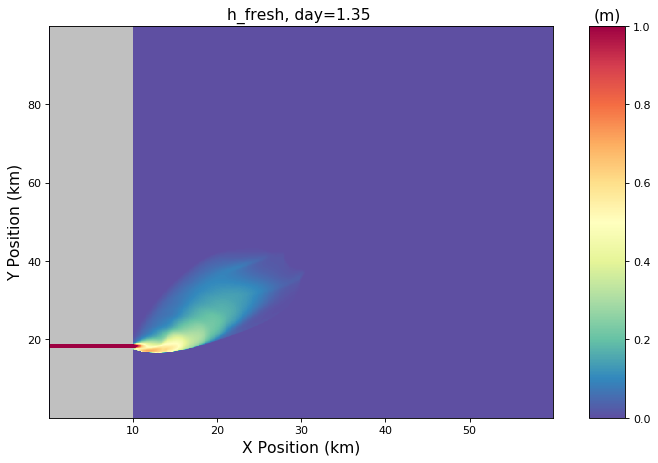

In [49]:
%cd /work/eay/MITgcm_data/Experiment32/

Salthf = nc.Dataset('Salt.nc')
newmask = Salthf.variables['S'][0,:,:,:]
mask = Salthf.variables['S'][30,0,:,:]
Salt_hf = Salthf.variables['S'][index,:,:,:]; Salt_hf[newmask==0]=np.nan
Sref = Salt_hf*0.0+34.0
hf=0.1*np.nansum((Sref-Salt_hf)/34.0,axis=0)
hf[(mask==0)]=-10000000
%cd /work/eay/MITgcm_data/

fig = plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([.9, 0.1, 0.05, 0.7])


quad1 = ax1.pcolormesh(xq/1000,yq/1000,hf,cmap='Spectral_r',vmin=0,vmax=1)
quad1.cmap.set_under('silver')
quad1.cmap.set_over(quad1.cmap(1.))

#ax1.set_xlim(0,30)
ax1.set_title('h_fresh, day=%04.2f ' %(index/48.), fontsize=14)
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('X Position (km)',fontsize=14)
ax1.set_ylabel('Y Position (km)',fontsize=14)
cb1 = fig.colorbar(quad1,ax2)
plt.title('(m)', fontsize=14)

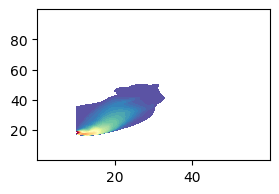

In [50]:
fig = plt.figure(figsize=(3, 2), dpi= 100, facecolor='w', edgecolor='k')
#levels = np.arange(0,1.,0.1)
levels = np.arange(0,1.,0.02)
cbar_mappable = plt.contourf(xq/1000,yq/1000,hf,levels=levels,cmap='Spectral_r')


<function matplotlib.pyplot.show(*args, **kw)>

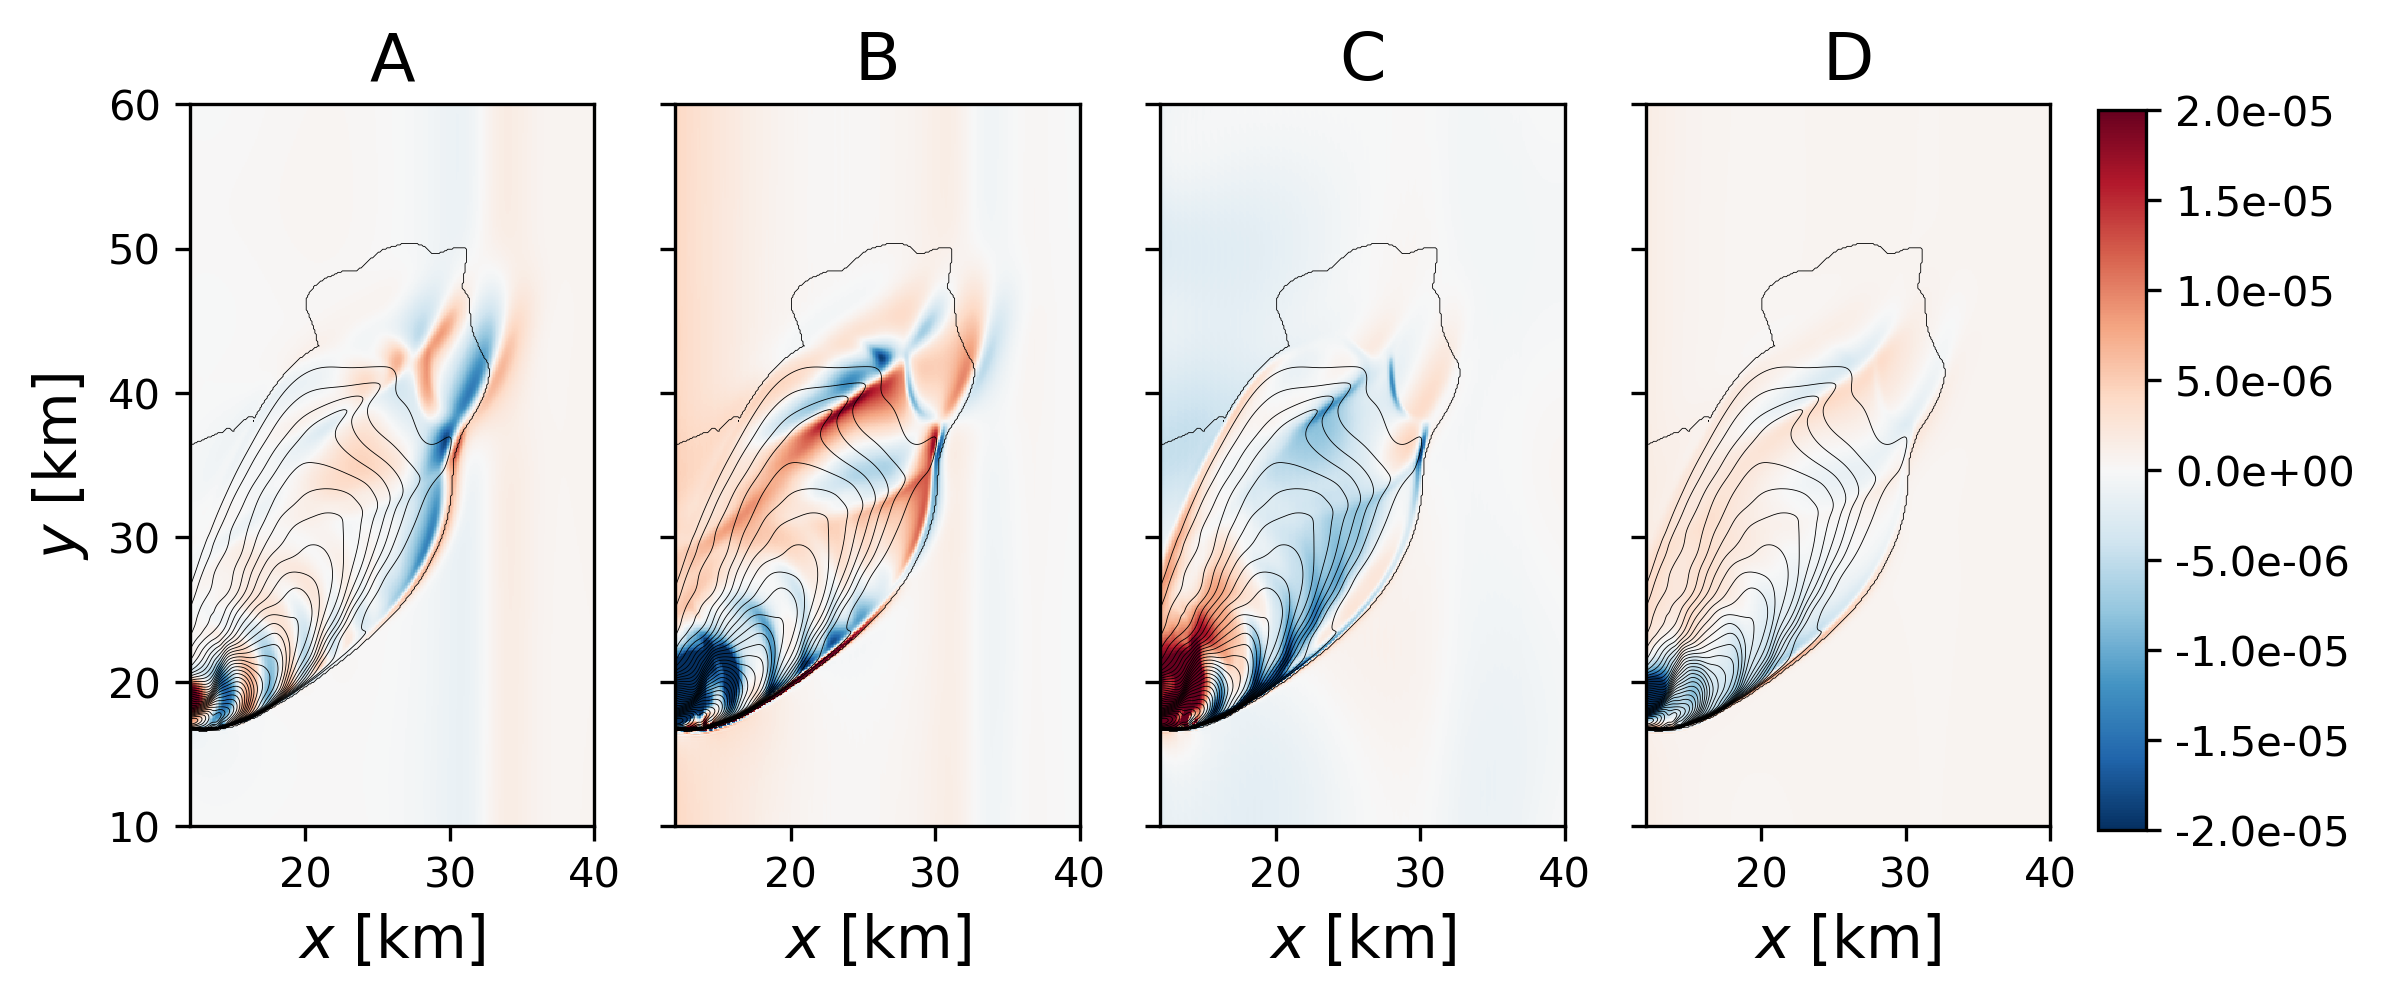

In [51]:
fig = plt.figure(figsize=(8, 6), dpi= 300, facecolor='w', edgecolor='k')

cmin=-.2e-4; cmax=.2e-4;

ax1 = fig.add_subplot(1,4,1)
ax1.pcolormesh(xq/1000,yq/1000,term1[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax1.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax1.set_ylabel('$y$ [km]',fontsize=14); ax1.set_xlabel('$x$ [km]',fontsize=14)
ax1.set_xlim([12,40]); ax1.set_ylim([10,60]);
#ax1.set_ylim([20,70]); 
ax1.set_aspect('equal'); 
#ax1.set_title(r'$\partial u/\partial t$')
ax1.set_title('A',fontsize=16)

ax2 = fig.add_subplot(1,4,2)
ax2.pcolormesh(xq/1000,yq/1000,term2[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax2.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax2.set_xlabel('$x$ [km]',fontsize=14); 
ax2.set_xlim([12,40]); ax2.set_ylim([10,60]);
ax2.set_aspect('equal'); 
ax2.set_yticklabels([])
#ax2.set_title(r'$u \partial u/\partial x+v \partial u/\partial y$')
ax2.set_title('B',fontsize=16)

ax3 = fig.add_subplot(1,4,3)
ax3.pcolormesh(xq/1000,yq/1000,term3[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax3.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax3.set_xlabel('$x$ [km]',fontsize=14); 
ax3.set_xlim([12,40]); ax3.set_ylim([10,60]);
ax3.set_aspect('equal'); 
ax3.set_yticklabels([])
#ax3.set_title(r'$-f(v-v_E)+g\partial \eta/\partial x$')
ax3.set_title('C',fontsize=16)

ax4 = fig.add_subplot(1,4,4)
cbarplot=ax4.pcolormesh(xq/1000,yq/1000,term4[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax4.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)

ax4.set_xlabel('$x$ [km]',fontsize=14); ax1.set_xlabel('$x$ [km]')
ax4.set_xlim([12,40]); ax4.set_ylim([10,60]);
ax4.set_yticklabels([])
ax4.set_aspect('equal'); 
ax4.set_title('D',fontsize=16)
#ax4.set_title(r'$\partial u/\partial t+u \partial u/\partial x+v \partial u/\partial y -f(v-v_E)+g\partial \eta/\partial x$')
#ax4.colorbar(format='%.2e')

cbar = fig.colorbar(mappable=cbarplot, cax=fig.add_axes([0.92,0.3,0.02,0.4]),format='%.1e')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

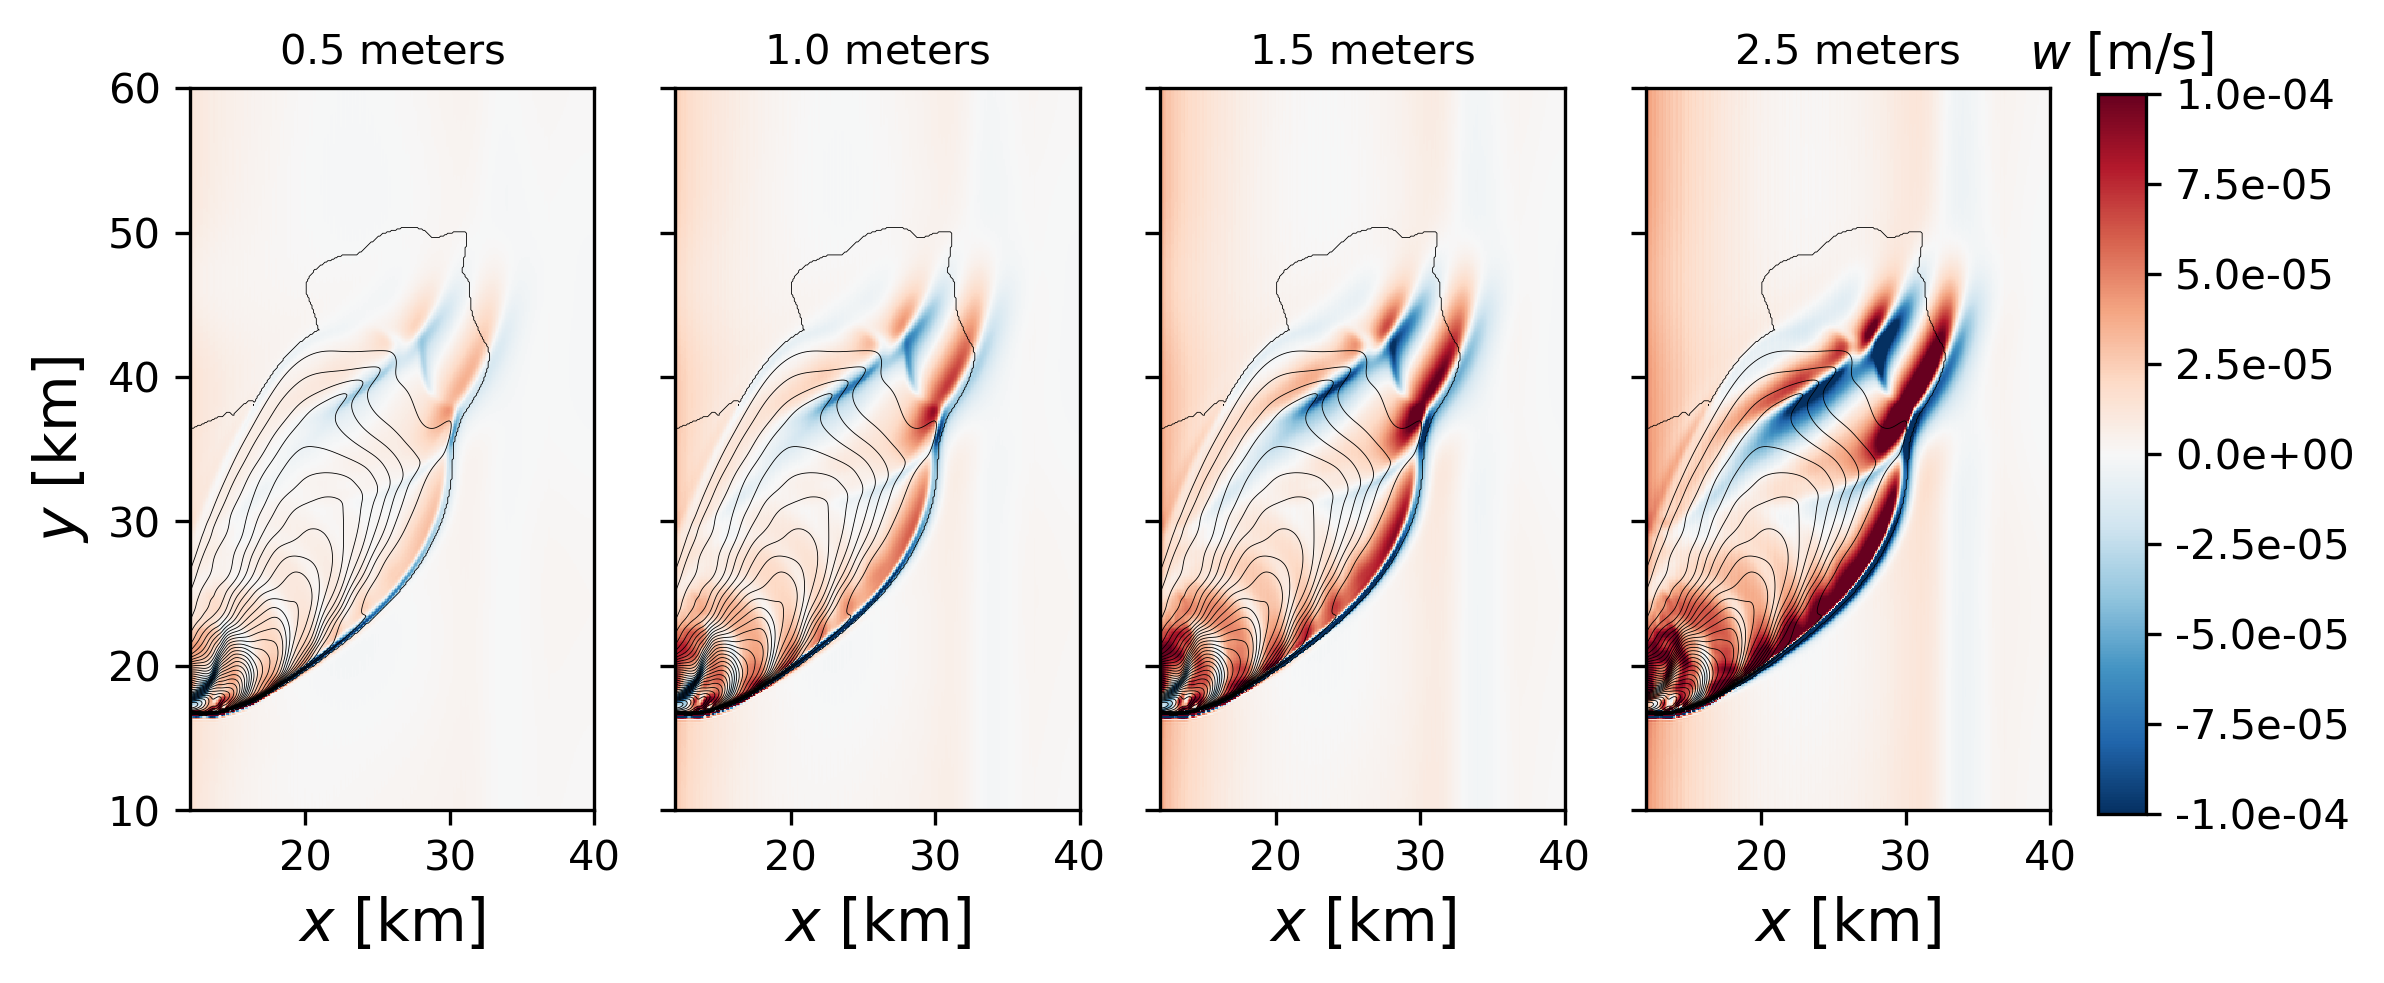

In [52]:
fig = plt.figure(figsize=(8, 6), dpi= 300, facecolor='w', edgecolor='k')

cmin=-1e-4; cmax=1e-4;

ax1 = fig.add_subplot(1,4,1)
ax1.pcolormesh(xq/1000,yq/1000,w_5[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax1.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax1.set_ylabel('$y$ [km]',fontsize=14); ax1.set_xlabel('$x$ [km]',fontsize=14)
ax1.set_xlim([12,40]); ax1.set_ylim([10,60]);
#ax1.set_ylim([20,70]); 
ax1.set_aspect('equal'); 
#ax1.set_title(r'$\partial u/\partial t$')
ax1.set_title('$0.5$ meters',fontsize=10)

ax2 = fig.add_subplot(1,4,2)
ax2.pcolormesh(xq/1000,yq/1000,w_10[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax2.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax2.set_xlabel('$x$ [km]',fontsize=14); 
ax2.set_xlim([12,40]); ax2.set_ylim([10,60]);
ax2.set_aspect('equal'); 
ax2.set_yticklabels([])
ax2.set_title('$1.0$ meters',fontsize=10)

ax3 = fig.add_subplot(1,4,3)
ax3.pcolormesh(xq/1000,yq/1000,w_15[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax3.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax3.set_xlabel('$x$ [km]',fontsize=14); 
ax3.set_xlim([12,40]); ax3.set_ylim([10,60]);
ax3.set_aspect('equal'); 
ax3.set_yticklabels([])
#ax3.set_title(r'$-f(v-v_E)+g\partial \eta/\partial x$')
ax3.set_title('$1.5$ meters',fontsize=10)

ax4 = fig.add_subplot(1,4,4)
cbarplot=ax4.pcolormesh(xq/1000,yq/1000,w_25[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax4.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)

ax4.set_xlabel('$x$ [km]',fontsize=14); ax1.set_xlabel('$x$ [km]')
ax4.set_xlim([12,40]); ax4.set_ylim([10,60]);
ax4.set_yticklabels([])
ax4.set_aspect('equal'); 
ax4.set_title('$2.5$ meters',fontsize=10)
#ax4.set_title(r'$\partial u/\partial t+u \partial u/\partial x+v \partial u/\partial y -f(v-v_E)+g\partial \eta/\partial x$')
#ax4.colorbar(format='%.2e')

cbar = fig.colorbar(mappable=cbarplot, cax=fig.add_axes([0.92,0.3,0.02,0.4]),format='%.1e')
cbar.ax.set_title('$w$ [m/s]')
plt.show

In [53]:
##Putting all terms on LHS of momentum equation except for the forcing!
# Y COMPONENT
dvdt = v.differentiate("T")
udvdx= u*(v.differentiate("X"))
vdvdy= v*(v.differentiate("Y"))
coriolis_term=f*(u)
PGF  = 9.81*(Eta.differentiate("Y"))
hor_viscosity=-10*(v.differentiate("X")).differentiate("X")-10*(v.differentiate("Y")).differentiate("Y")
wind_forcing = xr.zeros_like(Eta)+0.0/(0.1*1000)
vert_viscosity=-1e-4*(grid_info.interp(V[index,0:5,:,:],axis='Y').differentiate("Z")).differentiate("Z")
vert_viscosity=vert_viscosity[1,:,:]

error = dvdt+udvdx+vdvdy+coriolis_term+PGF+hor_viscosity+vert_viscosity-wind_forcing


term1 = dvdt
term2 = udvdx + vdvdy
term3 = f*(u-u_E)+PGF
#term4 = dvdt+udvdx + vdvdy+f*(u-u_E)+PGF
term4 = term1+term2+term3+hor_viscosity-(error-np.nanmean(error[index,:,400:500]))
print('done')

done


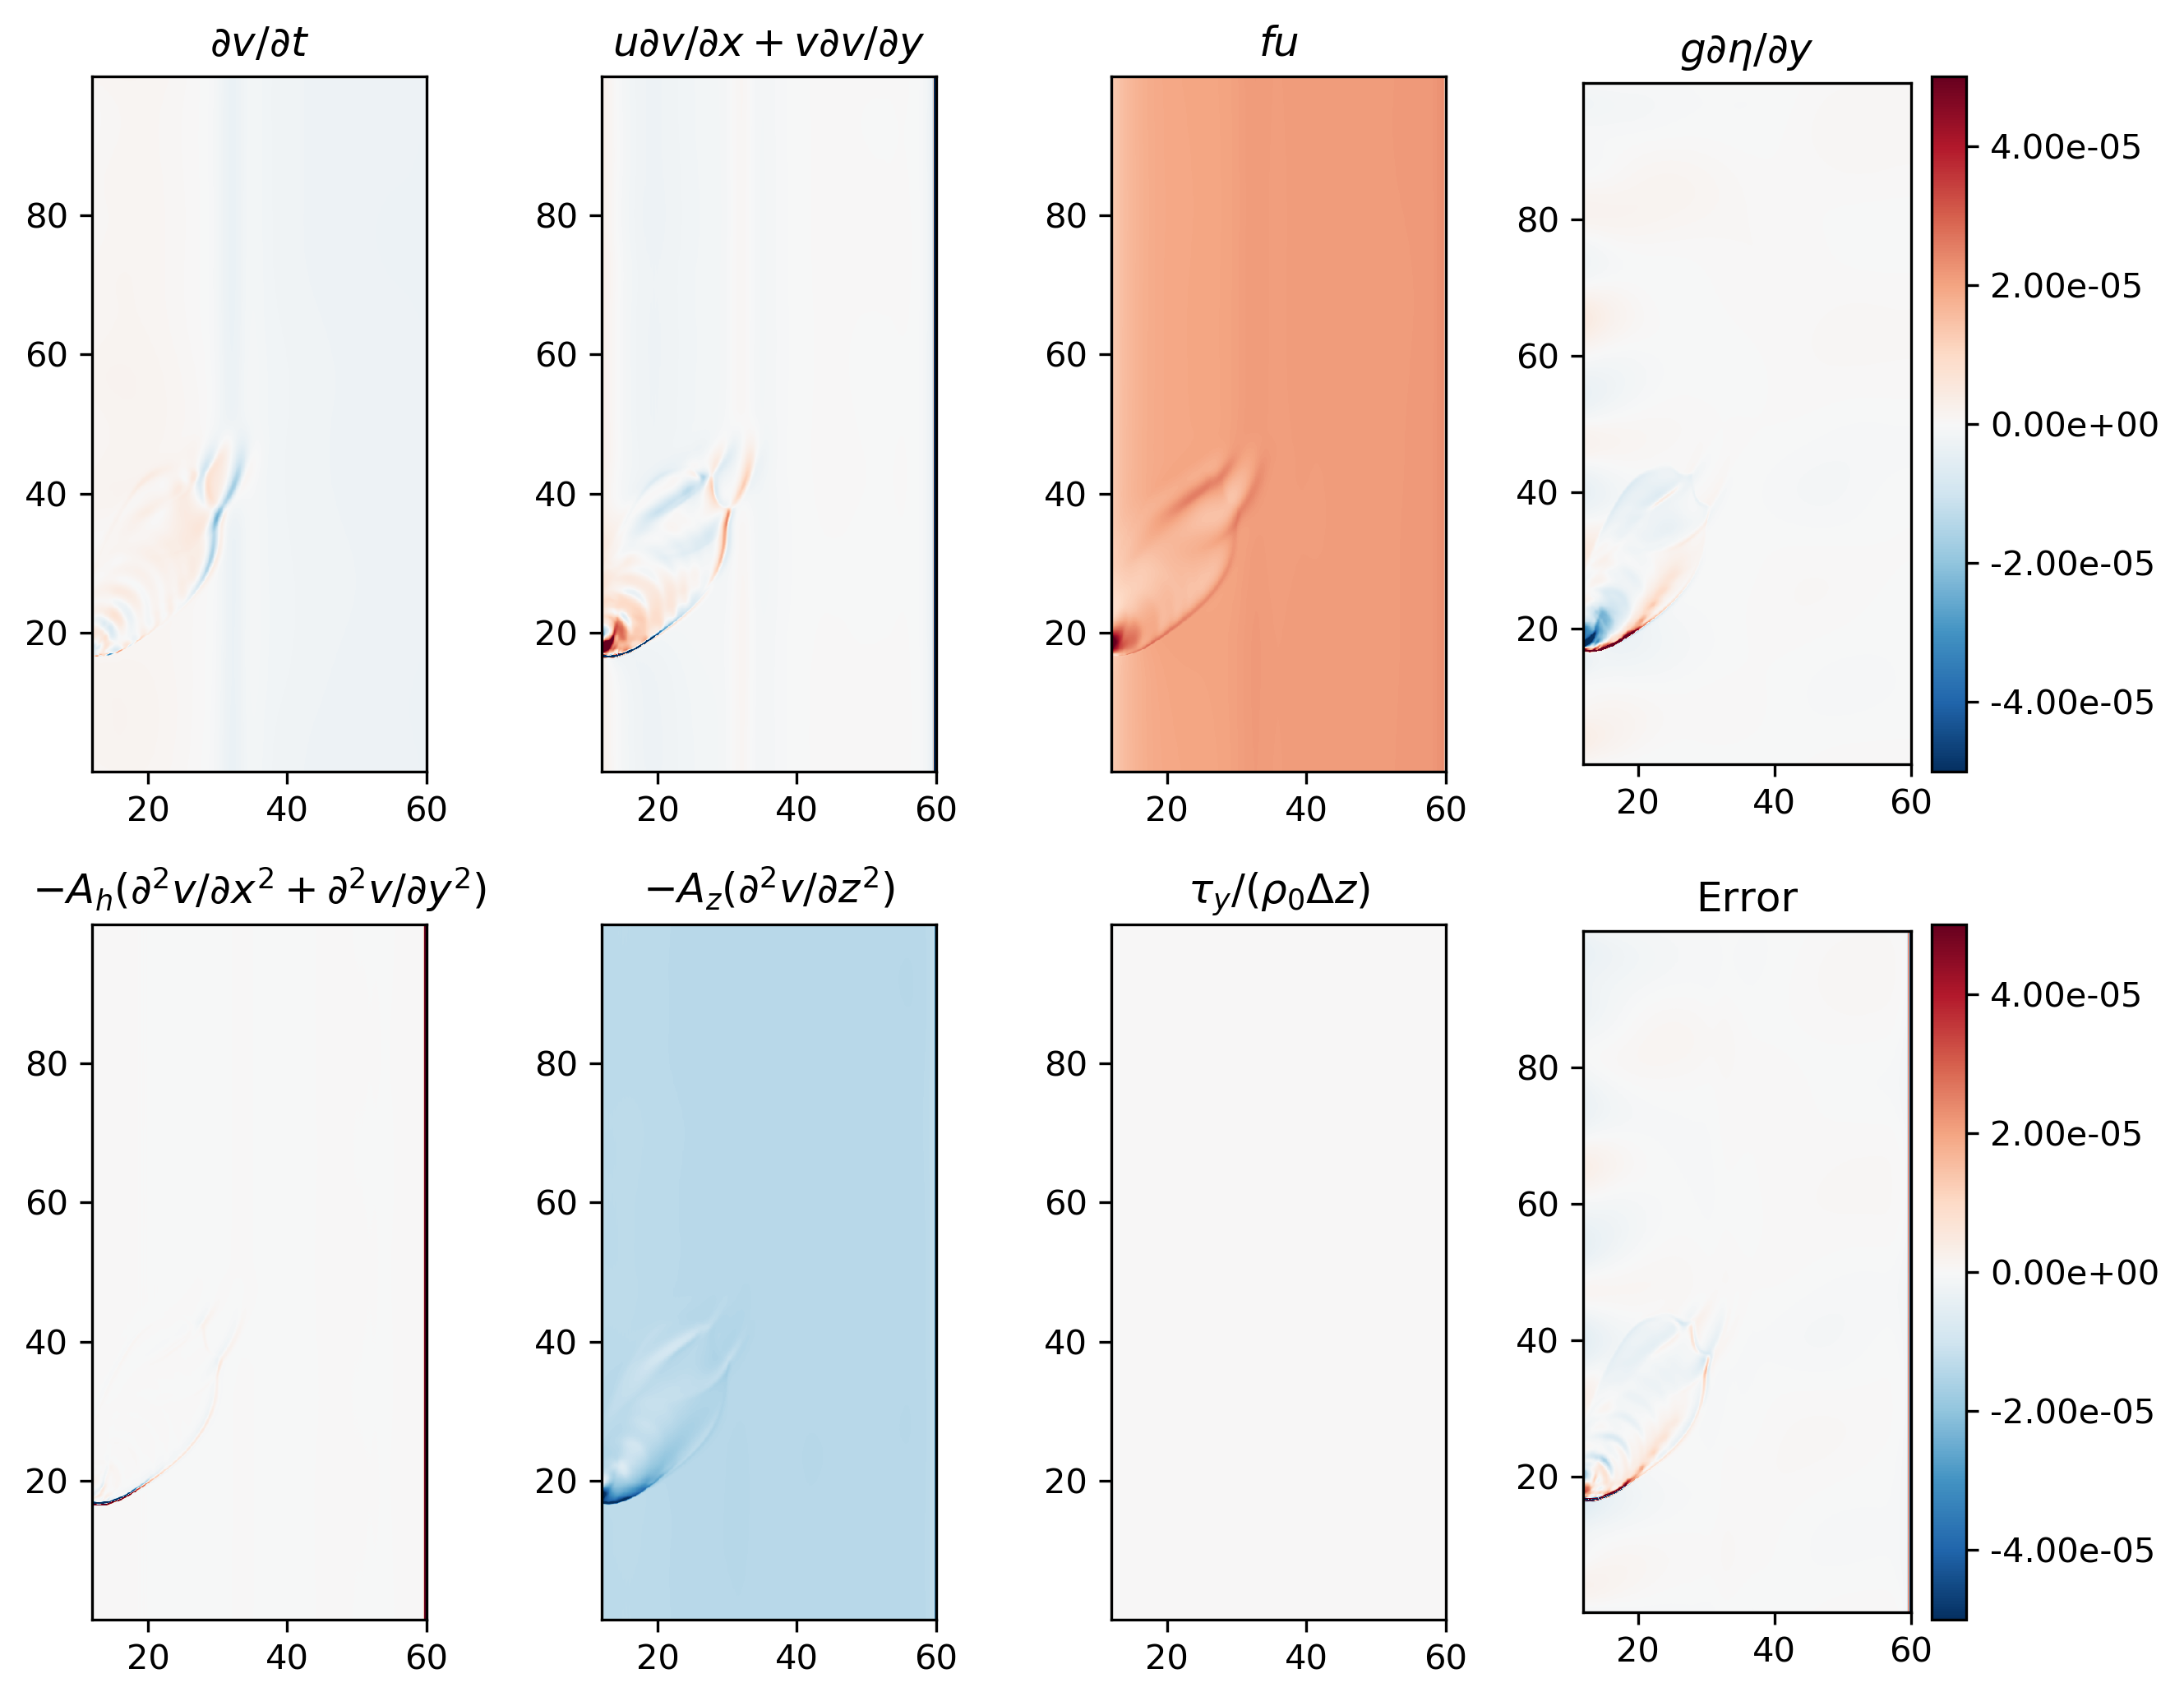

In [55]:
plt.figure(figsize=(9,7),dpi=300)



cmin=-.5e-4; cmax=.5e-4;
plt.subplot(2,4,1)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,dvdt[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial v/\partial t$')
#plt.colorbar()

plt.subplot(2,4,2)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,udvdx[index]+vdvdy[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$u \partial v/\partial x+v \partial v/\partial y$')
#plt.colorbar()



plt.subplot(2,4,3)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,coriolis_term[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$fu$')


plt.subplot(2,4,4)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,PGF[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$g \partial \eta/\partial y$')
plt.colorbar(format='%.2e')

plt.subplot(2,4,5)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,hor_viscosity[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-A_h (\partial^2 v/\partial x^2 + \partial^2 v/\partial y^2)$')
#plt.colorbar()

plt.subplot(2,4,6)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,vert_viscosity,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-A_z (\partial^2 v/\partial z^2)$')

plt.subplot(2,4,7)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,wind_forcing[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\tau_y/(\rho_0 \Delta z)$')
#plt.colorbar()



plt.subplot(2,4,8)
plt.xlim([12,60])
plt.pcolormesh(xq/1000,yq/1000,error[index]-np.nanmean(error[index,:,400:500]),norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Error')
plt.colorbar(format='%.2e')


plt.tight_layout()

<function matplotlib.pyplot.show(*args, **kw)>

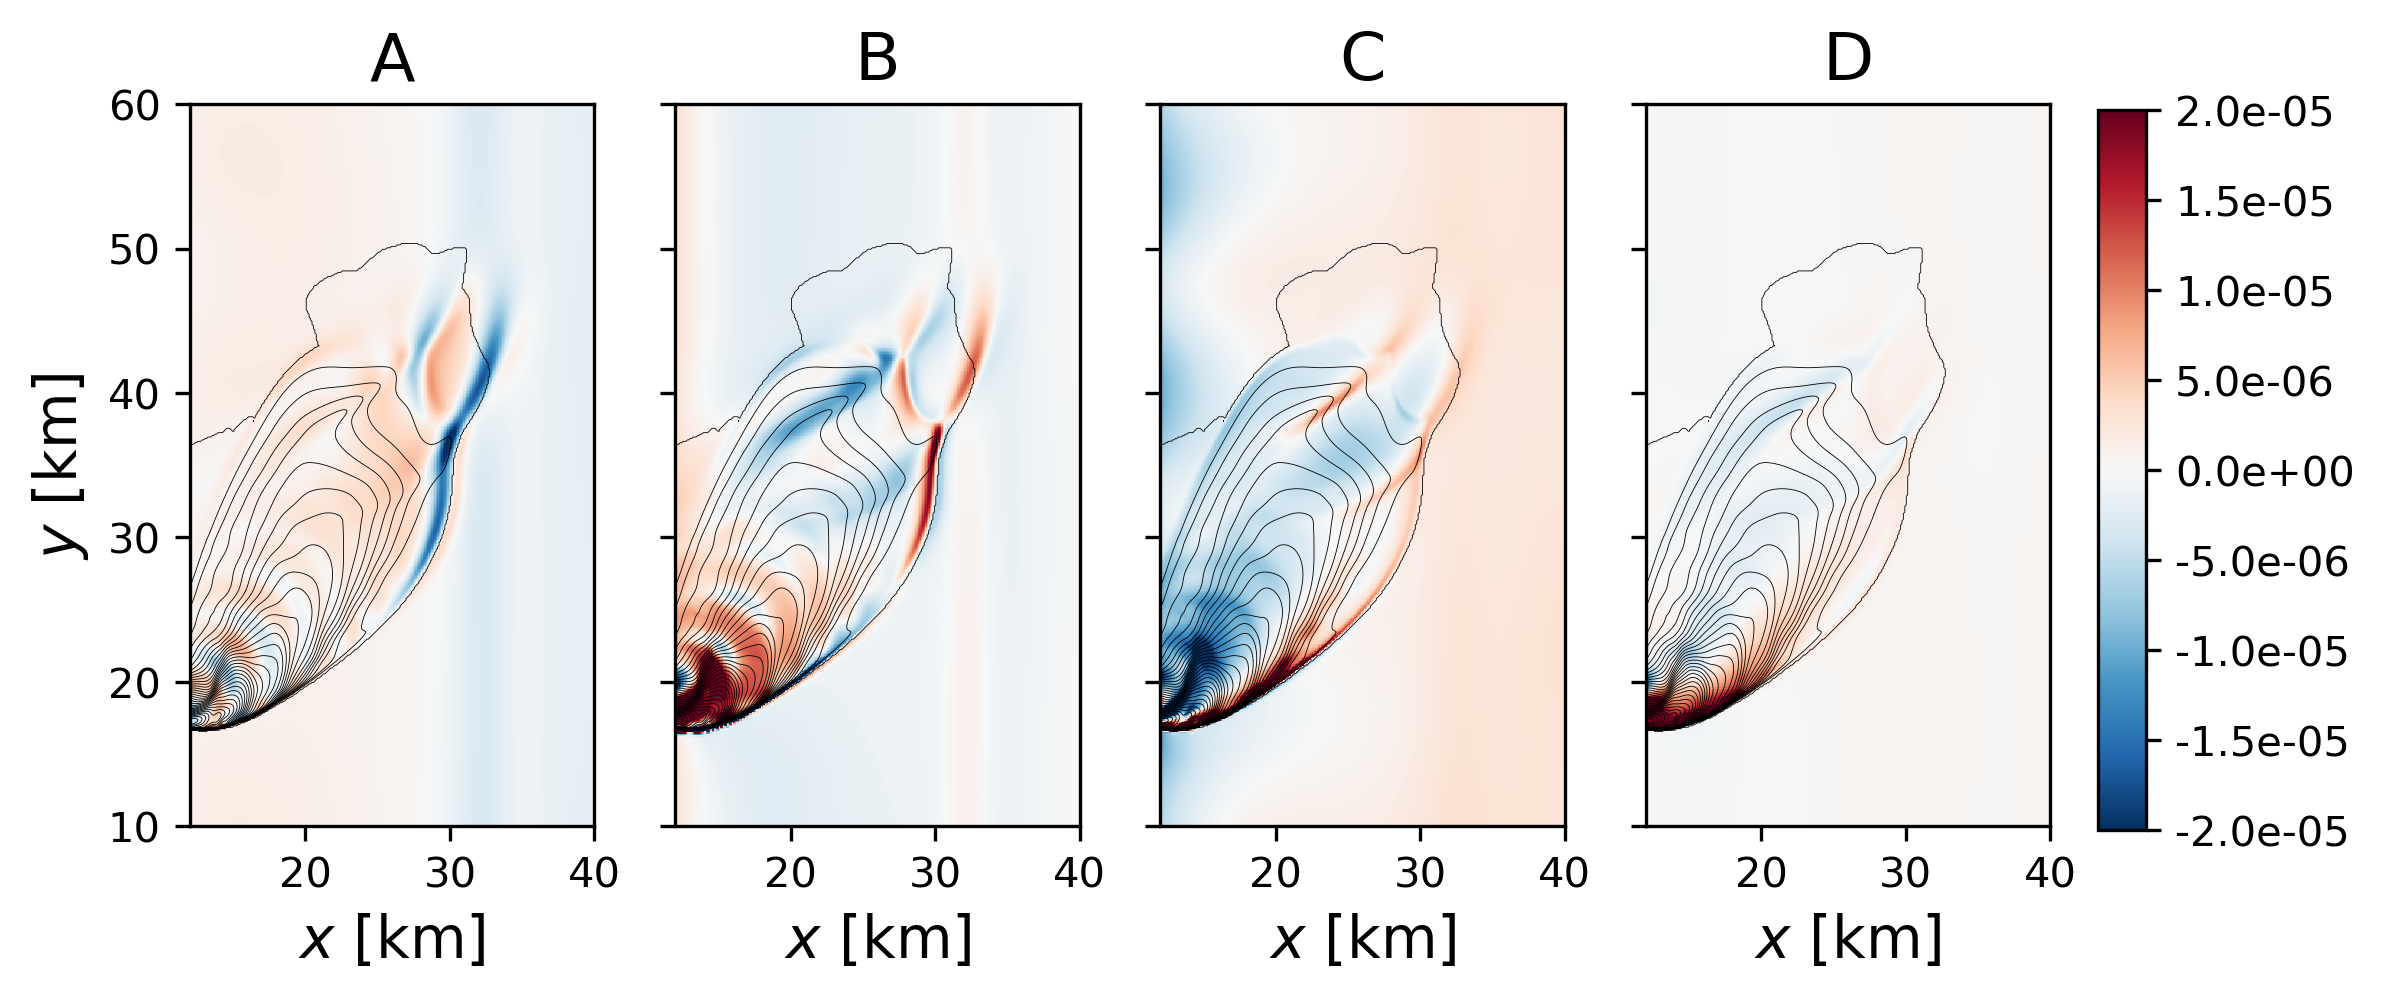

In [56]:
fig = plt.figure(figsize=(8, 6), dpi= 300, facecolor='w', edgecolor='k')

cmin=-.2e-4; cmax=.2e-4;

ax1 = fig.add_subplot(1,4,1)
ax1.pcolormesh(xq/1000,yq/1000,term1[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax1.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax1.set_ylabel('$y$ [km]',fontsize=14); ax1.set_xlabel('$x$ [km]',fontsize=14)
ax1.set_xlim([12,40]); ax1.set_ylim([10,60]);
#ax1.set_ylim([20,70]); 
ax1.set_aspect('equal'); 
#ax1.set_title(r'$\partial u/\partial t$')
ax1.set_title('A',fontsize=16)

ax2 = fig.add_subplot(1,4,2)
ax2.pcolormesh(xq/1000,yq/1000,term2[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax2.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax2.set_xlabel('$x$ [km]',fontsize=14); 
ax2.set_xlim([12,40]); ax2.set_ylim([10,60]);
ax2.set_aspect('equal'); 
ax2.set_yticklabels([])
#ax2.set_title(r'$u \partial u/\partial x+v \partial u/\partial y$')
ax2.set_title('B',fontsize=16)

ax3 = fig.add_subplot(1,4,3)
ax3.pcolormesh(xq/1000,yq/1000,term3[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax3.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)
ax3.set_xlabel('$x$ [km]',fontsize=14); 
ax3.set_xlim([12,40]); ax3.set_ylim([10,60]);
ax3.set_aspect('equal'); 
ax3.set_yticklabels([])
#ax3.set_title(r'$-f(v-v_E)+g\partial \eta/\partial x$')
ax3.set_title('C',fontsize=16)

ax4 = fig.add_subplot(1,4,4)
cbarplot=ax4.pcolormesh(xq/1000,yq/1000,term4[index],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
ax4.contour(xq/1000,yq/1000,hf,levels=levels,colors='k',linewidths=.2)

ax4.set_xlabel('$x$ [km]',fontsize=14); ax1.set_xlabel('$x$ [km]')
ax4.set_xlim([12,40]); ax4.set_ylim([10,60]);
ax4.set_yticklabels([])
ax4.set_aspect('equal'); 
ax4.set_title('D',fontsize=16)
#ax4.set_title(r'$\partial u/\partial t+u \partial u/\partial x+v \partial u/\partial y -f(v-v_E)+g\partial \eta/\partial x$')
#ax4.colorbar(format='%.2e')

cbar = fig.colorbar(mappable=cbarplot, cax=fig.add_axes([0.92,0.3,0.02,0.4]),format='%.1e')
plt.show